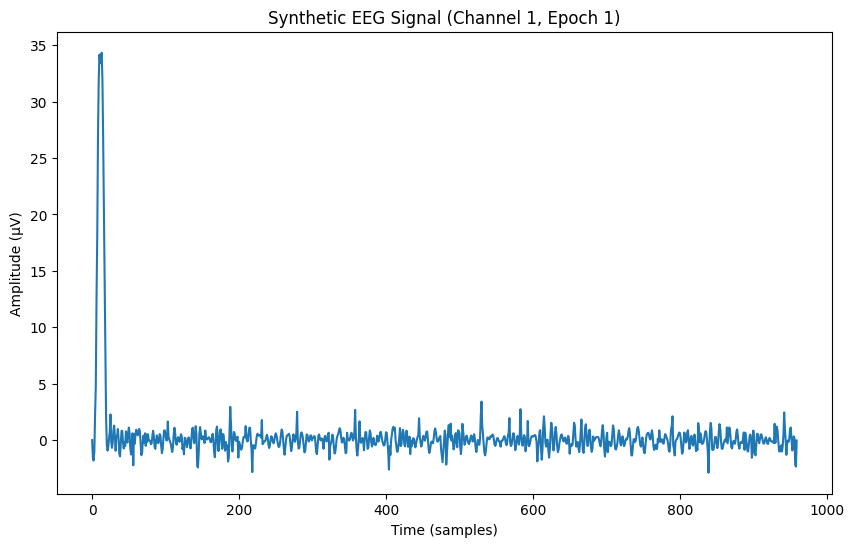

In [4]:
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

# Parameters
n_channels = 32
sampling_rate = 64  # Hz
epoch_duration = 15  # seconds
n_samples = epoch_duration * sampling_rate
n_epochs = 60
n_frequencies = 6
n_volumes = 18
n_ears = 2
stimulus_rate = 5  # Hz
stimuli_per_epoch = epoch_duration * stimulus_rate
total_stimuli = n_frequencies * n_volumes * n_ears
repeats_per_stimulus = int((n_epochs * stimuli_per_epoch) / total_stimuli)
stimulus_latencies = np.random.randint(50, 200, size=total_stimuli)  # Simulated latencies in ms

# Simulate EEG signal
def bandpass_filter(data, lowcut, highcut, fs, order=6):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, data)

# Baseline EEG: Random Gaussian noise
def generate_baseline_eeg(n_channels, n_samples):
    eeg = np.random.randn(n_channels, n_samples)
    return bandpass_filter(eeg, 3, 15, sampling_rate)

# Simulate AEP for a stimulus
def generate_aep(n_channels, n_samples, latency, amplitude=1.0):
    aep = np.zeros((n_channels, n_samples))
    peak = int(latency / (1000 / sampling_rate))
    aep[:, peak : peak + 10] = amplitude * np.hanning(10)  # 10-sample AEP window
    return aep

# Add artifacts (e.g., eye blinks)
def add_artifacts(eeg, artifact_probability=0.1):
    artifact_mask = np.random.rand(*eeg.shape) < artifact_probability
    eeg[artifact_mask] += np.random.uniform(-2, 2, size=artifact_mask.sum())
    return eeg

# Generate synthetic dataset
eeg_data = []
stimulus_metadata = []

for epoch in range(n_epochs):
    epoch_eeg = generate_baseline_eeg(n_channels, n_samples)
    epoch_metadata = []
    for _ in range(stimuli_per_epoch):
        frequency = np.random.choice(range(n_frequencies))
        volume = np.random.choice(range(n_volumes))
        ear = np.random.choice(["left", "right"])
        latency = stimulus_latencies[frequency * n_volumes + volume]
        aep = generate_aep(n_channels, n_samples, latency, amplitude=np.random.uniform(0.5, 1.5))
        epoch_eeg += aep
        epoch_metadata.append({"frequency": frequency, "volume": volume, "ear": ear, "latency": latency})
    epoch_eeg = add_artifacts(epoch_eeg)
    eeg_data.append(epoch_eeg)
    stimulus_metadata.append(epoch_metadata)

# Convert to arrays
eeg_data = np.stack(eeg_data, axis=0)  # Shape: (epochs, channels, time_samples)

# Example metadata format
metadata = {
    "stimuli": stimulus_metadata,
    "channels": [f"Ch{i}" for i in range(1, n_channels + 1)],
    "sampling_rate": sampling_rate,
    "epoch_duration": epoch_duration,
}

# Visualize one epoch
plt.figure(figsize=(10, 6))
plt.plot(eeg_data[10, 10, :])  # Plot first channel of the first epoch
plt.title("Synthetic EEG Signal (Channel 1, Epoch 1)")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (µV)")
plt.show()

In [9]:
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch
import random

# Parameters
n_participants = 15
n_channels = 32
sampling_rate = 64  # Downsampled
epoch_duration = 15  # seconds
n_samples = epoch_duration * sampling_rate
n_epochs = 60
frequencies = [250, 500, 1000, 2000, 4000, 8000]
volume_levels_ctrl = np.arange(-10, 75, 5)
volume_levels_hi = np.arange(0, 85, 5)
stimulus_duration_ms = 30
stimulus_latency = 100  # ms (AEP peak latency)

# Simulate baseline EEG (Gaussian noise)
def generate_baseline_eeg(n_channels, n_samples):
    baseline = np.random.normal(0, 1, (n_channels, n_samples))
    return bandpass_filter(baseline, 3, 15, sampling_rate)

# Bandpass filter function
def bandpass_filter(data, lowcut, highcut, fs, order=6):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, data, axis=-1)

# Add AEP to EEG
def add_aep(eeg, latency, amplitude=1.0):
    peak = int(latency / (1000 / sampling_rate))
    aep_shape = np.hanning(10) * amplitude  # Hanning window for AEP
    eeg[:, peak : peak + len(aep_shape)] += aep_shape
    return eeg

# Add noise (artifacts)
def add_artifacts(eeg, artifact_probability=0.1):
    artifact_indices = np.random.rand(*eeg.shape) < artifact_probability
    eeg[artifact_indices] += np.random.normal(0, 1, artifact_indices.sum())
    return eeg

# Generate participant data
eeg_dataset = []
metadata = []

for p in range(n_participants):
    group = "HI" if p < 10 else "CTRL"
    worse_ear = "right" if p < 8 else "left" if p < 10 else None
    volume_levels = volume_levels_hi if group == "HI" else volume_levels_ctrl

    for epoch in range(n_epochs):
        epoch_eeg = generate_baseline_eeg(n_channels, n_samples)
        epoch_metadata = []

        for freq in frequencies:
            for vol in volume_levels:
                ear = random.choice(["left", "right"])
                latency = stimulus_latency + random.randint(-10, 10)  # Slight variation in latency
                amplitude = np.random.uniform(0.5, 1.5)  # Random AEP amplitude
                epoch_eeg = add_aep(epoch_eeg, latency, amplitude)
                epoch_metadata.append({
                    "participant": p,
                    "group": group,
                    "frequency": freq,
                    "volume": vol,
                    "ear": ear,
                    "latency": latency,
                    "amplitude": amplitude,
                })

        epoch_eeg = add_artifacts(epoch_eeg)
        eeg_dataset.append(epoch_eeg)
        metadata.append(epoch_metadata)

# Convert to numpy arrays for storage and analysis
eeg_dataset = np.stack(eeg_dataset, axis=0)  # Shape: (n_epochs * n_participants, n_channels, n_samples)

# Save dataset
np.save("synthetic_eeg_dataset.npy", eeg_dataset)
np.save("synthetic_metadata.npy", metadata)

print("Synthetic EEG dataset and metadata saved.")

Synthetic EEG dataset and metadata saved.


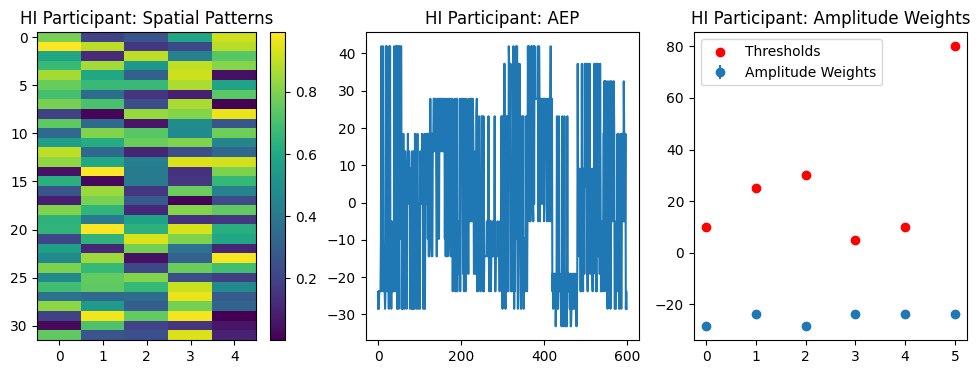

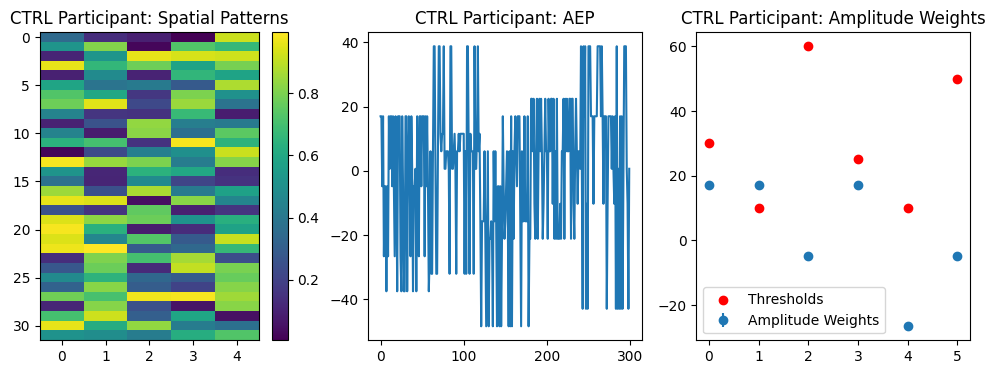

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA
import random

# Set random seed for reproducibility
np.random.seed(42)

# Synthetic data parameters
n_channels = 32
sampling_rate = 256
downsample_rate = 64
n_samples_per_epoch = downsample_rate * 15
n_epochs = 60
frequencies = [250, 500, 1000, 2000, 4000, 8000]
volume_levels_ctrl = np.arange(-10, 75, 5)
volume_levels_hi = np.arange(0, 85, 5)

n_frequencies = len(frequencies)
n_volumes = len(volume_levels_ctrl)

# Generate synthetic participant data
def generate_synthetic_participants(n_hi, n_ctrl):
    participants = []
    for _ in range(n_hi):
        participants.append({
            "group": "HI",
            "thresholds": {freq: random.choice(volume_levels_hi) for freq in frequencies}
        })
    for _ in range(n_ctrl):
        participants.append({
            "group": "CTRL",
            "thresholds": {freq: random.choice(volume_levels_ctrl) for freq in frequencies}
        })
    return participants

n_HI = 10
n_CTRL = 5
participant_data = generate_synthetic_participants(n_HI, n_CTRL)

# Generate synthetic EEG data
def generate_synthetic_eeg(participant, n_epochs, n_channels, n_samples_per_epoch):
    eeg_data = []
    amplitude_weights = []
    for _ in range(n_epochs):
        freq = random.choice(frequencies)
        volume = participant["thresholds"][freq]
        noise = np.random.normal(0, 0.5, (n_channels, n_samples_per_epoch))
        signal = np.sin(2 * np.pi * freq * np.linspace(0, 1, n_samples_per_epoch))
        signal = np.tile(signal, (n_channels, 1)) * (volume / 100)  # Scale by volume
        eeg_epoch = signal + noise
        eeg_data.append(eeg_epoch)
        amplitude_weights.append(volume / 100)  # Normalize to range [0, 1]
    return np.array(eeg_data), np.array(amplitude_weights)

# Generate data for all participants
eeg_data_all = []
amplitude_weights_all = []
for participant in participant_data:
    eeg_data, amplitude_weights = generate_synthetic_eeg(
        participant, n_epochs, n_channels, n_samples_per_epoch
    )
    eeg_data_all.append(eeg_data)
    amplitude_weights_all.append(amplitude_weights)

# Convert lists to NumPy arrays
eeg_data_all = np.array(eeg_data_all)
amplitude_weights_all = np.array(amplitude_weights_all)

# Canonical Correlation Analysis (CCA)
def apply_cca(eeg_data, amplitude_weights, n_components=1):
    reshaped_epochs = eeg_data.reshape(eeg_data.shape[0], -1)
    cca = CCA(n_components=n_components)
    X_c, Y_c = cca.fit_transform(reshaped_epochs, amplitude_weights.reshape(-1, 1))
    return X_c, Y_c, cca

X_c_HI, _, cca_HI = apply_cca(eeg_data_all[:n_HI].reshape(-1, n_channels, n_samples_per_epoch),
                              amplitude_weights_all[:n_HI].flatten())
X_c_CTRL, _, cca_CTRL = apply_cca(eeg_data_all[n_HI:].reshape(-1, n_channels, n_samples_per_epoch),
                                  amplitude_weights_all[n_HI:].flatten())

# Plotting Figure 1
def plot_figure_1(X_c, participant, title):
    thresholds = [participant["thresholds"][freq] for freq in frequencies]
    
    plt.figure(figsize=(12, 4))
    
    # Spatial patterns (mocked as random patterns for simplicity)
    plt.subplot(1, 3, 1)
    plt.imshow(np.random.rand(n_channels, 5), aspect="auto", cmap="viridis")
    plt.colorbar()
    plt.title(f"{title}: Spatial Patterns")
    
    # AEP
    plt.subplot(1, 3, 2)
    aep = np.mean(X_c, axis=1)  # Aggregate across components
    plt.plot(aep)
    plt.title(f"{title}: AEP")
    
    # Amplitude weights
    plt.subplot(1, 3, 3)
    amplitude_means = np.mean(X_c, axis=1)[:len(thresholds)]
    amplitude_stds = np.std(X_c, axis=1)[:len(thresholds)]
    
    plt.scatter(range(len(thresholds)), thresholds, c='r', label="Thresholds")
    plt.errorbar(
        range(len(thresholds)),
        amplitude_means,
        yerr=amplitude_stds,
        fmt="o",
        label="Amplitude Weights",
    )
    plt.title(f"{title}: Amplitude Weights")
    plt.legend()

plot_figure_1(X_c_HI, participant_data[0], "HI Participant")
plot_figure_1(X_c_CTRL, participant_data[n_HI], "CTRL Participant")
plt.show()

Frequency: 250 Hz
  All Groups: R²=0.14
  HI Only: R²=0.25
Frequency: 500 Hz
  All Groups: R²=0.26
  HI Only: R²=0.01
Frequency: 1000 Hz
  All Groups: R²=0.17
  HI Only: R²=0.01
Frequency: 2000 Hz
  All Groups: R²=0.05
  HI Only: R²=0.17
Frequency: 4000 Hz
  All Groups: R²=0.03
  HI Only: R²=0.18
Frequency: 8000 Hz
  All Groups: R²=0.09
  HI Only: R²=0.01


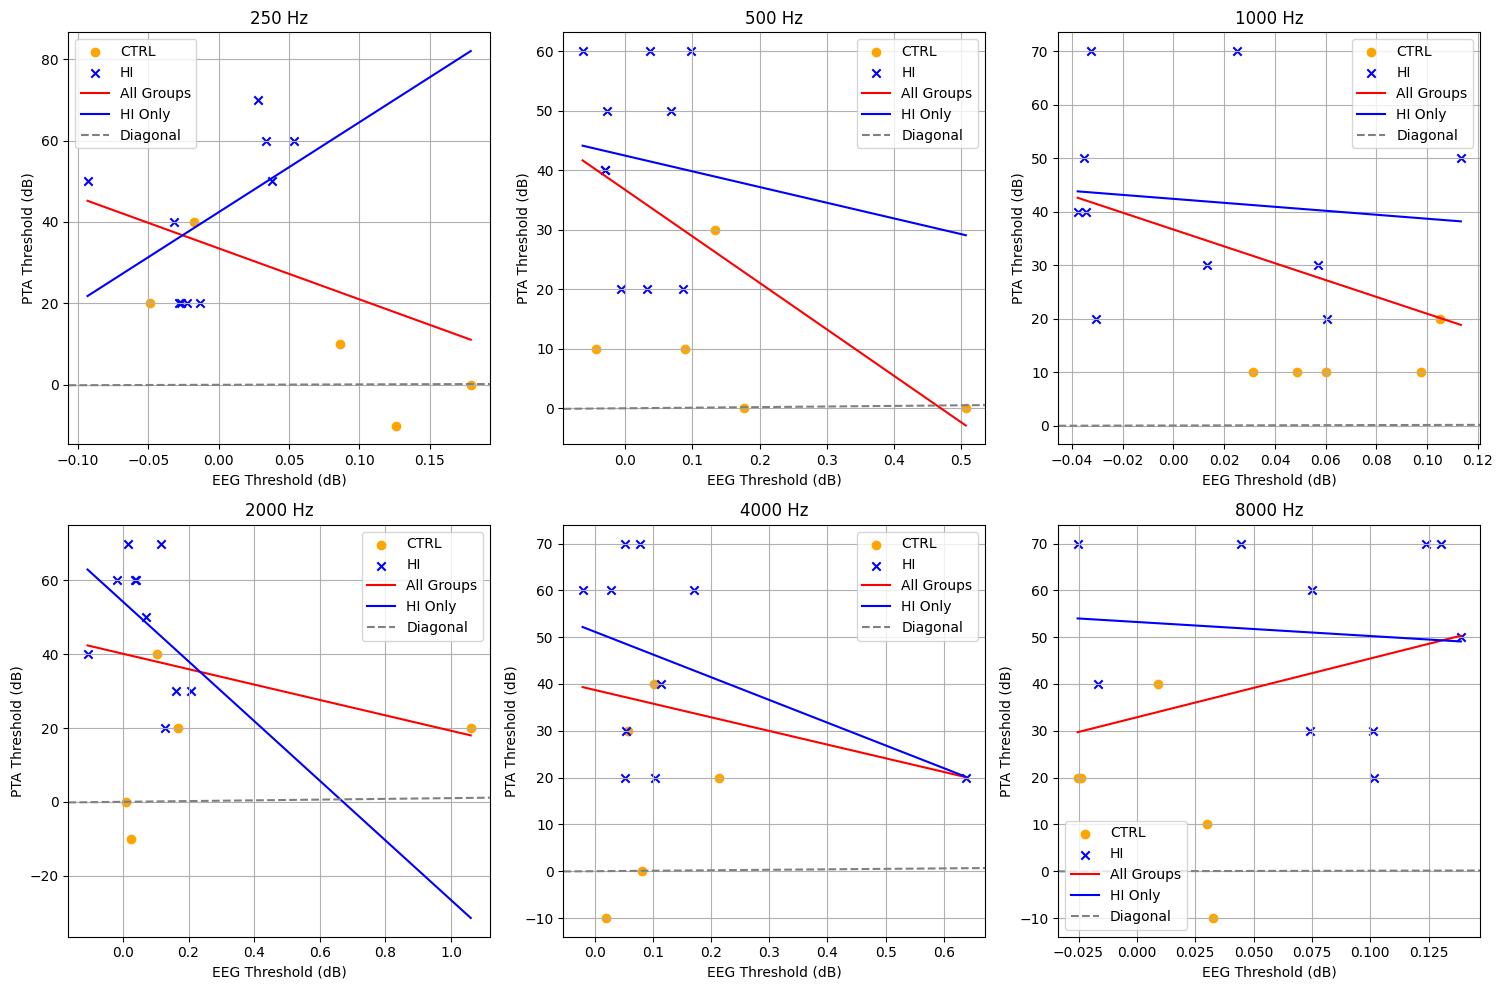

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Constants
n_participants = 15
n_HI = 10
n_CTRL = 5
n_frequencies = 6
volume_levels = np.array([-10, 0, 10, 20, 30, 40, 50, 60, 70, 80])  # Volume in dB
frequencies = np.array([250, 500, 1000, 2000, 4000, 8000])  # Frequency in Hz
n_epochs = 60

# Simulate data
np.random.seed(42)
participant_data = []
for i in range(n_participants):
    is_HI = i < n_HI
    thresholds = np.random.choice(volume_levels[3:9] if is_HI else volume_levels[:6], size=n_frequencies)
    amplitude_weights = np.array([
        [np.exp(-(v - t) ** 2 / 50) + 0.1 * np.random.randn() for v in volume_levels]
        for t in thresholds
    ])
    participant_data.append({
        "group": "HI" if is_HI else "CTRL",
        "thresholds": thresholds,
        "amplitude_weights": amplitude_weights
    })

# Aggregate amplitude weights into a single array for easier processing
amplitude_weights_all = np.array([
    [np.median(participant["amplitude_weights"][:, f]) for f in range(n_frequencies)]
    for participant in participant_data
])

# PTA thresholds (simulate as ground truth)
pta_thresholds_all = np.array([
    participant["thresholds"] for participant in participant_data
])

# Prepare EEG thresholds
eeg_thresholds_all = amplitude_weights_all
group_labels = ["HI"] * n_HI + ["CTRL"] * n_CTRL

# Perform regression and plot results
def plot_linear_regression_grid(eeg_thresholds, pta_thresholds, group_labels, frequencies, volume_levels):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, freq in enumerate(frequencies):
        ax = axes[i]
        eeg = eeg_thresholds[:, i]
        pta = pta_thresholds[:, i]
        
        hi_mask = np.array(group_labels) == "HI"
        ctrl_mask = np.array(group_labels) == "CTRL"
        
        # Fit regression models
        reg_all = LinearRegression().fit(eeg.reshape(-1, 1), pta)
        reg_hi = LinearRegression().fit(eeg[hi_mask].reshape(-1, 1), pta[hi_mask])
        
        # Plot all groups
        ax.scatter(eeg[ctrl_mask], pta[ctrl_mask], label="CTRL", color="orange", marker="o")
        ax.scatter(eeg[hi_mask], pta[hi_mask], label="HI", color="blue", marker="x")
        
        x_vals = np.linspace(eeg.min(), eeg.max(), 100).reshape(-1, 1)
        ax.plot(x_vals, reg_all.predict(x_vals), color="red", label="All Groups")
        ax.plot(x_vals, reg_hi.predict(x_vals), color="blue", label="HI Only")
        
        ax.axline((0, 0), slope=1, linestyle="--", color="gray", label="Diagonal")
        ax.set_title(f"{freq} Hz")
        ax.set_xlabel("EEG Threshold (dB)")
        ax.set_ylabel("PTA Threshold (dB)")
        ax.legend()
        ax.grid()
        
        # Print regression statistics
        print(f"Frequency: {freq} Hz")
        print(f"  All Groups: R²={r2_score(pta, reg_all.predict(eeg.reshape(-1, 1))):.2f}")
        print(f"  HI Only: R²={r2_score(pta[hi_mask], reg_hi.predict(eeg[hi_mask].reshape(-1, 1))):.2f}")
    
    plt.tight_layout()
    plt.show()

# Generate plots and results
plot_linear_regression_grid(eeg_thresholds_all, pta_thresholds_all, group_labels, frequencies, volume_levels)

In [36]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.cross_decomposition import CCA
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# -------------------------
# Data Preparation
# -------------------------

def generate_synthetic_eeg(n_participants, n_channels, n_samples, n_frequencies):
    """Generate synthetic EEG data mimicking the structure of the experiment."""
    np.random.seed(42)
    eeg_data = np.random.randn(n_participants, n_channels, n_samples)
    amplitude_weights = np.abs(np.random.randn(n_participants, n_frequencies))
    thresholds = np.random.randint(30, 80, size=(n_participants, n_frequencies))
    return eeg_data, amplitude_weights, thresholds

# Parameters
n_participants = 20
n_channels = 32
n_samples = 1024
n_frequencies = 6

eeg_data, amplitude_weights, thresholds = generate_synthetic_eeg(n_participants, n_channels, n_samples, n_frequencies)
train_participants = int(0.8 * n_participants)

# Splitting data
train_eeg = torch.tensor(eeg_data[:train_participants], dtype=torch.float32)
test_eeg = torch.tensor(eeg_data[train_participants:], dtype=torch.float32)
train_thresholds = torch.tensor(thresholds[:train_participants], dtype=torch.float32)
test_thresholds = torch.tensor(thresholds[train_participants:], dtype=torch.float32)

# -------------------------
# 1. Benchmark with CCA
# -------------------------

def apply_cca(eeg_data, amplitude_weights, n_components=1):
    cca = CCA(n_components=n_components)
    reshaped_eeg = eeg_data.reshape(eeg_data.shape[0], -1)
    X_c, Y_c = cca.fit_transform(reshaped_eeg, amplitude_weights)
    return X_c, Y_c

# Apply CCA
cca_X_c, cca_Y_c = apply_cca(train_eeg.numpy(), amplitude_weights[:train_participants])
baseline_model = LinearRegression()
baseline_model.fit(cca_X_c, train_thresholds)

# -------------------------
# 2. CNN-TCN Hybrid Model
# -------------------------

class EEGHybridModel(nn.Module):
    def __init__(self, input_channels, seq_length, n_frequencies):
        super(EEGHybridModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(1, 5), padding=(0, 2)),
            nn.ReLU(),
            nn.MaxPool2d((1, 2)),
            nn.Conv2d(32, 64, kernel_size=(1, 5), padding=(0, 2)),
            nn.ReLU(),
            nn.MaxPool2d((1, 2))
        )
        self.tcn = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(128, n_frequencies, kernel_size=5, padding=2)
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = x.unsqueeze(1)  # Add channel dimension (N, 1, C, T)
        x = self.cnn(x)  # Pass through CNN layers
        x = x.squeeze(2)  # Squeeze the height dimension (N, F, T)
        x = self.tcn(x)  # Pass through TCN layers (N, F, T)
        x = x.mean(dim=-1)  # Global average pooling (N, F)
        return x

# Training and Evaluation
def train_model(model, dataloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(dataloader)}")

# DataLoader
class EEGDataset(Dataset):
    def __init__(self, eeg_data, thresholds):
        self.eeg_data = eeg_data
        self.thresholds = thresholds

    def __len__(self):
        return len(self.thresholds)

    def __getitem__(self, idx):
        return self.eeg_data[idx], self.thresholds[idx]

train_dataset = EEGDataset(train_eeg, train_thresholds)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Train CNN-TCN Model
cnn_tcn_model = EEGHybridModel(n_channels, n_samples, n_frequencies).to(device)
optimizer = optim.Adam(cnn_tcn_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_model(cnn_tcn_model, train_loader, criterion, optimizer)

# Evaluate on test data
cnn_tcn_model.eval()
with torch.no_grad():
    cnn_tcn_predictions = cnn_tcn_model(test_eeg.to(device)).cpu().numpy()

# Compare predictions
frequencies = ["250 Hz", "500 Hz", "1 kHz", "2 kHz", "4 kHz", "8 kHz"]
plt.figure(figsize=(12, 8))
for i, freq in enumerate(frequencies):
    plt.subplot(2, 3, i + 1)
    plt.plot(test_thresholds[:, i], label="Ground Truth", marker="o")
    plt.plot(cnn_tcn_predictions[:, i], label="CNN-TCN", marker="s")
    plt.title(freq)
    plt.xlabel("Participants")
    plt.ylabel("Thresholds")
    plt.legend()

plt.tight_layout()
plt.show()

# -------------------------
# 3. Variational Autoencoder
# -------------------------

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim * 2)  # Mean and log variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        q_params = self.encoder(x)
        mean, log_var = q_params[:, :latent_dim], q_params[:, latent_dim:]
        std = torch.exp(0.5 * log_var)
        z = mean + std * torch.randn_like(std)
        x_recon = self.decoder(z)
        return x_recon, mean, log_var

def vae_loss(recon_x, x, mean, log_var):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_div = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return recon_loss + kl_div

vae_model = VAE(input_dim=n_channels * n_samples, latent_dim=10).to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=0.001)

for epoch in range(10):
    vae_model.train()
    epoch_loss = 0.0
    for inputs, _ in train_loader:
        inputs = inputs.to(device).view(inputs.size(0), -1)
        vae_optimizer.zero_grad()
        recon_x, mean, log_var = vae_model(inputs)
        loss = vae_loss(recon_x, inputs, mean, log_var)
        loss.backward()
        vae_optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch + 1}, VAE Loss: {epoch_loss / len(train_loader)}")

# -------------------------
# Comparative Plots
# -------------------------

# Predictions from each model
with torch.no_grad():
    baseline_predictions = baseline_model.predict(cca_X_c)
    cnn_tcn_predictions = cnn_tcn_model(test_eeg.to(device)).cpu().numpy()
    vae_reconstructions = vae_model(test_eeg.view(test_eeg.size(0), -1).to(device))[0].cpu().numpy()

# Plotting
frequencies = ["250 Hz", "500 Hz", "1 kHz", "2 kHz", "4 kHz", "8 kHz"]
plt.figure(figsize=(12, 8))
for i, freq in enumerate(frequencies):
    plt.subplot(2, 3, i + 1)
    plt.plot(test_thresholds[:, i], label="Ground Truth", marker="o")
    plt.plot(baseline_predictions[:, i], label="CCA", marker="x")
    plt.plot(cnn_tcn_predictions[:, i], label="CNN-TCN", marker="s")
    plt.plot(vae_reconstructions[:, i], label="VAE", marker="^")
    plt.title(freq)
    plt.xlabel("Participants")
    plt.ylabel("Thresholds")
    plt.legend()

plt.tight_layout()
plt.show()

RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [4, 64, 32, 256]